<a href="https://colab.research.google.com/github/lucabmanning/563-luca/blob/main/Luca_Project1_Revision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Key Takeaways:

1. I really like to over-complicate things.

a. Shoot for the moon and even if you miss, you will land among the stars.

b. By that, I mean that I initially tried to simulate water/ice molecules. I think I bit off more than I could chew, and had to come back down to Earth and focus on a simpler Lennard-Jones type simulation. I’ll get there eventually.

c. When I was working on the water molecule simulation, I got some good looking equilibration curves, but I made my code a mess. I was getting completely unrealistic values when computing energy calculations, std dev.'s, and heat capacity. I am hoping to get back in there and simplify it and take some more time to learn from my mistakes.

2. It’s cool to try to make things run at the same time (giving outputs of different scenarios simultaneously), but I've learned that can be a slippery slope.

a. Why is it a slippery slope? Python needs to be tuned properly to run calculations in parallel. If you’re like me, someone who’s okay at coding, it’s usually best to keep things simple. If the code is producing values that seem unrealistic, there’s a good chance that they are unrealistic.

b. For instance, I tried running the code with T = 0.5 and 2.0 at each of N/V = 0.5 and 0.7 all in one cell, but the output suggested that the first two were the same and the last two were the same, with a standard deviation of 0.0000. LOL.

In [76]:
from tabulate import tabulate

table_data = [
    ["Statepoint (N/V, T)", "N", "nSteps", "nSamples", "<E>/N", "std(E)/N"],
    ["(0.5, 0.5)", 32, 50000, 20, -3.73, 0.15],
    ["(0.7, 0.5)", 32, 50000, 20, -4.66, 0.08],
    ["(0.7, 2.0)", 32, 50000, 30, -3.63, 0.29],
    ["(0.7, 2.0)", 32, 50000, 73, -3.40, 0.33]
]

# Print as nice table
print(tabulate(table_data[1:], headers=table_data[0], tablefmt="pretty"))


+---------------------+----+--------+----------+-------+----------+
| Statepoint (N/V, T) | N  | nSteps | nSamples | <E>/N | std(E)/N |
+---------------------+----+--------+----------+-------+----------+
|     (0.5, 0.5)      | 32 | 50000  |    20    | -3.73 |   0.15   |
|     (0.7, 0.5)      | 32 | 50000  |    20    | -4.66 |   0.08   |
|     (0.7, 2.0)      | 32 | 50000  |    30    | -3.63 |   0.29   |
|     (0.7, 2.0)      | 32 | 50000  |    73    | -3.4  |   0.33   |
+---------------------+----+--------+----------+-------+----------+


In [61]:
import numpy
import matplotlib.pyplot as plt

def pbc(d,L):
  for i,x in enumerate(d):
    if x > L/2:
      d[i] = x-L
    elif x <= -L/2:
      d[i] = x+L
  return d

def distance(ri,rj,L):
  d = pbc(rj-ri,L)
  return numpy.linalg.norm(d)

def lj(r,epsilon=1.,sigma=1.):
  return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

class simulation():
  def __init__(self,N=100,L=10,T=2.0,maxD=0.1,maxSteps=10,debug=False,seed=2):
    numpy.random.seed(seed)
    self.N = N
    self.L = L
    self.T = T
    self.maxD = maxD
    self.accept = 0
    self.reject = 0
    self.rcut = 2.5
    self.pos = numpy.zeros((N,3))
    self.debug = debug
    self.maxSteps = maxSteps
    self.energies = numpy.zeros(maxSteps)
    for i in range(self.N):
      while True:
        self.pos[i] = numpy.random.uniform(low=-L/2,high=L/2,size=3)
        if self.energy(i,initializing=True)<=0.:
          break
    self.E = self.energy()
    for i in range(self.maxSteps):
      self.trial()
      if self.debug:
        print("{:03}:   {:.2f}".format(i, self.E))
      self.energies[i] = self.E

  def energy(self,i=None,initializing=False):
    E = 0
    if i is not None and initializing:
      pi = self.pos[i]
      for j in range(i):
        r = distance(pi,self.pos[j],self.L)
        if r <= self.rcut:
          E += lj(r)
      return E
    if i is None:
      for i in range(self.N-1):
        pi = self.pos[i]
        for j in range(i+1,self.N):
          r = distance(pi,self.pos[j],self.L) # speed up with numpy
          if r <= self.rcut:
            E += lj(r)
      return E

  def trial(self):
    i = numpy.random.randint(self.N)
    oldP = numpy.copy(self.pos[i])
    oldE = self.E
    oldEi = self.energy()
    d = numpy.random.uniform(low=-self.maxD,high=self.maxD,size=3)
    newP = pbc(oldP+d,self.L)
    self.pos[i] = newP
    newEi = self.energy()
    dE = newEi - oldEi
    if numpy.random.uniform() <= numpy.exp(-dE/self.T):
      if self.debug:
        print("accept")
      self.accept += 1
      self.E += dE
      return
    else:
      if self.debug:
        print("reject")
      self.pos[i] = oldP
      self.reject += 1
      self.E = oldE
      return

In [62]:
def autocorr1D(array):
  ft = numpy.fft.rfft(array - numpy.average(array))
  acorr = numpy.fft.irfft(ft * numpy.conjugate(ft)) / (len(array) * numpy.var(array))
  dt = numpy.where(acorr<0)[0][0]
  nsamples = len(array)//dt
  acorr = acorr[dt:nsamples]

  return nsamples, dt

In [60]:
density = 0.7
N = 20
V = N/density
L = V**(1/3)
print(L)
maxSteps = 50000
s = simulation(N=N, L=L, maxSteps = maxSteps,debug=False,seed=23)
print("{:02f} +/- {:02f}".format(s.energies.mean()/N, s.energies.std()/N))

3.0571070873287987
-3.403613 +/- 0.324758


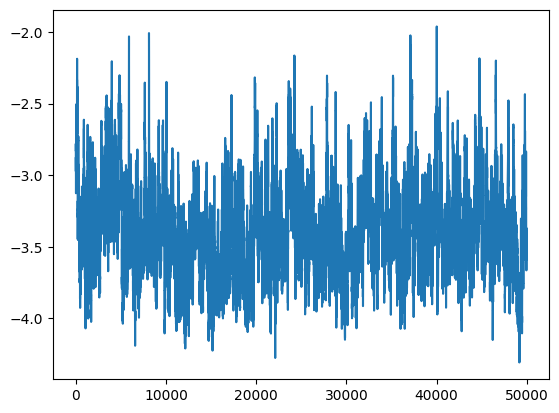

In [63]:
plt.plot(s.energies[0:]/N)
plt.show()

In [64]:
for start in range(0,10000,100):
  print(start, autocorr1D(s.energies[start:]))


0 (50, 997)
100 (48, 1021)
200 (29, 1666)
300 (30, 1655)
400 (29, 1692)
500 (29, 1672)
600 (48, 1025)
700 (48, 1024)
800 (29, 1670)
900 (29, 1650)
1000 (29, 1660)
1100 (29, 1661)
1200 (29, 1642)
1300 (29, 1648)
1400 (28, 1722)
1500 (28, 1693)
1600 (46, 1030)
1700 (47, 1023)
1800 (47, 1021)
1900 (47, 1021)
2000 (28, 1667)
2100 (29, 1647)
2200 (29, 1638)
2300 (29, 1635)
2400 (29, 1632)
2500 (29, 1632)
2600 (28, 1638)
2700 (46, 1021)
2800 (46, 1005)
2900 (46, 1006)
3000 (47, 997)
3100 (47, 994)
3200 (47, 992)
3300 (47, 987)
3400 (47, 982)
3500 (47, 979)
3600 (47, 969)
3700 (47, 973)
3800 (48, 959)
3900 (63, 730)
4000 (48, 943)
4100 (63, 725)
4200 (64, 710)
4300 (63, 722)
4400 (62, 724)
4500 (62, 725)
4600 (64, 704)
4700 (71, 638)
4800 (73, 612)
4900 (72, 618)
5000 (62, 722)
5100 (46, 970)
5200 (61, 730)
5300 (46, 957)
5400 (46, 957)
5500 (47, 945)
5600 (47, 941)
5700 (60, 730)
5800 (60, 726)
5900 (60, 724)
6000 (60, 727)
6100 (60, 725)
6200 (45, 956)
6300 (46, 939)
6400 (46, 947)
6500 (60

In [65]:
real_average = s.energies[4700::342].mean()/N
real_std = s.energies[4700::342].std()/N
print(real_average, real_std)

-3.4035903988051217 0.32793019592050593


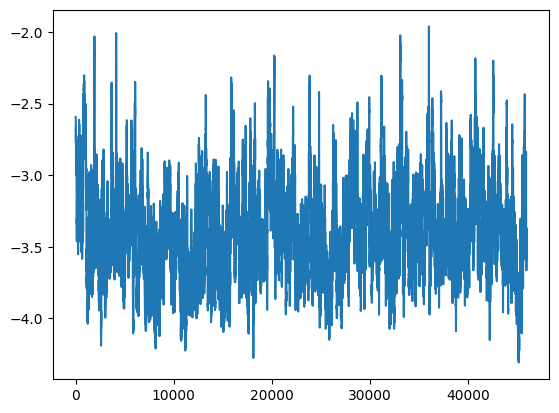

0
48


In [66]:
nsamples, dt = autocorr1D(s.energies[4000:]/N) # Changed this line to unpack only two values: nsamples, dt
# Now you can use a separate variable for indexing purposes, if necessary.
# For example, you could use numpy.arange or any other desired indexing technique
a = s.energies[4000:]/N # Creating a separate variable for what was intended for 'a'
plt.plot(a)
plt.show()
print(numpy.where(a<0)[0][0])
print(nsamples)

In [67]:
ns,dt = autocorr1D(s.energies[0::])
print(ns,dt)

50 997


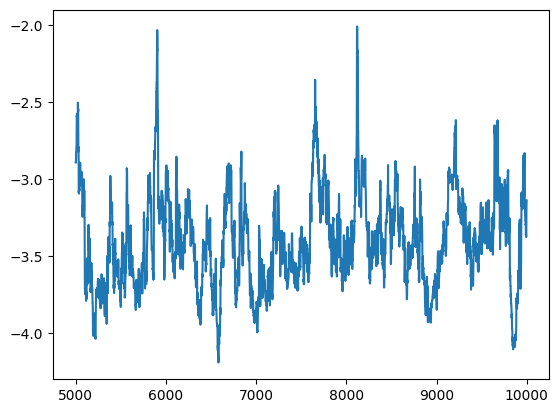

N=20, AverageE: -3.40


In [68]:
start = 5000
steps = 5000
plt.plot(range(start,start+steps),s.energies[start:start+steps]/N)
plt.show()
print("N={}, AverageE: {:.2f}".format(N,s.energies[maxSteps//2:].mean()/N))
# per particle around -4.25 with  N=32, density .7, L=3.57, 10k maxSteps
# per particle around -3.91 with  N=20, density .7, L=3.057, 10k maxSteps
# per particle around  with  N=28, density .7, L=3.057, 10k maxSteps


In [59]:
for N in range(20,51,5):
  density = 0.5
  V = N/density
  L = V**(1/3)
  maxSteps = 10000
  s = simulation(N=N, L=L, maxSteps = maxSteps,debug=False)
  print("N={}, AverageE: {:.2f}".format(N,s.energies[maxSteps//2:].mean()/N))

N=20, AverageE: -2.58
N=25, AverageE: -2.74
N=30, AverageE: -2.76
N=35, AverageE: -2.71
N=40, AverageE: -2.82
N=45, AverageE: -2.88
N=50, AverageE: -2.98


In [69]:
import time
for N in range(20,51,5):
    density = 0.7
    V = N/density
    L = V**(1/3)
    maxSteps = 10000
    t1 = time.perf_counter()
    s = simulation(N=N, L=L, maxSteps = maxSteps,debug=False)
    t2 = time.perf_counter()
    print("\nN=",N,"; {:.2f} seconds/sim".format(t2-t1))
    print("N={}, AverageE: {:.2f}".format(N,s.energies[maxSteps//2:].mean()/N))


N= 20 ; 35.07 seconds/sim
N=20, AverageE: -3.32

N= 25 ; 54.98 seconds/sim
N=25, AverageE: -3.62

N= 30 ; 80.97 seconds/sim
N=30, AverageE: -3.67

N= 35 ; 109.77 seconds/sim
N=35, AverageE: -3.69

N= 40 ; 141.20 seconds/sim
N=40, AverageE: -3.85

N= 45 ; 182.06 seconds/sim
N=45, AverageE: -3.83

N= 50 ; 202.79 seconds/sim
N=50, AverageE: -4.00
